<a href="https://colab.research.google.com/github/jacksonmcl/Federal_Funds_Rate_Model/blob/main/2.%20Data%20Visualization/data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.transforms as mtransforms
from datetime import datetime
from functools import reduce

from sklearn.preprocessing import MinMaxScaler

dfs = {}

### Github Setup

In [ ]:
! apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
!git -C "Federal_Funds_Rate_Model" pull || git clone https://github.com/jacksonmcl/Federal_Funds_Rate_Model.git "Federal_Funds_Rate_Model"

Already up to date.


### Read Data

In [ ]:
dfs['Federal_Funds_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Federal_Funds_Rate.csv')
dfs['Lagged_FFER'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Lagged_FFR.csv')

dfs['Discount_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Discount_Rate.csv')
dfs['Lagged_DR'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Lagged_DR.csv')
dfs['Prime_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Prime_Loan_Rate.csv')

dfs['Consumer_Price_Index'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Consumer_Price_Index.csv')
dfs['Producer_Price_Index'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Producer_Price_Index.csv')
dfs['Personal_Consumption_Expenditure'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Personal_Consumption_Expenditures.csv')
dfs['GDP_Recession_Index'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_GDP_Recession_Index.csv')

dfs['Unemployment_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Unemployment_Rate.csv')
dfs['Mortgage_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Mortgage_Rate.csv')
dfs['Auto_Loan_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Auto_Loan_Rate.csv')

In [ ]:
# Store in dataset_list
dataset_list = {
                'Lagged_FFER': dfs['Lagged_FFER'],
                'Discount_Rate': dfs['Discount_Rate'],
                'Lagged_DR': dfs['Lagged_DR'],
                'Prime_Rate': dfs['Prime_Rate'],
                'Consumer_Price_Index': dfs['Consumer_Price_Index'],
                'Producer_Price_Index': dfs['Producer_Price_Index'],
                'Personal_Consumption_Expenditure': dfs['Personal_Consumption_Expenditure'],
                'Unemployment_Rate': dfs['Unemployment_Rate'],
                'Mortgage_Rate': dfs['Mortgage_Rate'],
                'Auto_Loan_Rate': dfs['Auto_Loan_Rate']
            }

ffr_data = dfs['Federal_Funds_Rate']
# Inner join each dataset to the  dataset for comparison
df_list = {k:pd.merge(v, ffr_data, how='inner', on='Date') for (k,v) in dataset_list.items()}

In [ ]:
ffr_data

,Date,Value,ChangePercentMonth,ChangePercentYear
0,1954-07,0.80,NaN,NaN
1,1954-08,1.22,0.525000,NaN
2,1954-09,1.07,-0.122951,NaN
3,1954-10,0.85,-0.205607,NaN
4,1954-11,0.83,-0.023529,NaN
...,...,...,...,...
840,2024-07,5.33,0.000000,0.041016
841,2024-08,5.33,0.000000,0.000000
842,2024-09,5.13,-0.037523,-0.037523
843,2024-10,4.83,-0.058480,-0.093809


# Helper Functions

In [ ]:
# This function cleans a dataframe to change datetime to %Y-%m format
def df_dates_monthly(df, Date = 'Date'):
    clean_df = df.copy()
    clean_df[Date] = pd.to_datetime(clean_df[Date])
    clean_df[Date] = clean_df[Date].dt.strftime('%Y-%m')
    return clean_df

In [ ]:
def df_change_percent(df, Value = 'Value'):
    clean_df = df.copy()
    clean_df['ChangePercentMonth'] = round(clean_df[Value].pct_change(),6)
    clean_df['ChangePercentYear'] = round(clean_df[Value].pct_change(12),6)
    return clean_df

In [ ]:
def plot_comparison(base_df, comparison_df, base_label, comparison_label, Value='Value'):
    base_df = base_df.copy()
    comparison_df = comparison_df.copy()

    base_df.dropna(inplace=True)
    comparison_df.dropna(inplace=True)

    # Convert to Datetime
    base_df['Date'] = pd.to_datetime(base_df['Date'])
    comparison_df['Date'] = pd.to_datetime(comparison_df['Date'])

    # Scale values
    scaler = MinMaxScaler()
    base_df['Value'] = scaler.fit_transform(base_df[['Value']])
    comparison_df['Value'] = scaler.transform(comparison_df[['Value']])


    # Plot comparison metric
    plt.figure(figsize=(12, 6))
    plt.stackplot(base_df['Date'], base_df[Value], color='lightgray')
    sns.lineplot(x='Date', y=Value, data=comparison_df, label=comparison_label, color='steelblue')

    # Customize plot
    plt.title(f'{base_label} and {comparison_label}')
    plt.xlabel('Date')
    plt.ylabel(f'{comparison_label}')
    plt.grid(True)
    plt.legend()
    plt.show()


# Correlations

In [ ]:
# Calculate correlations between different variables to FFR
corr_list = {
            k:v[['Value_x', 'Value_y']].corr().iat[0,1] # [0,1] is the location on the correlation matrix that has the correlation of Value_x to Value_y
            for (k,v)
            in df_list.items()
        }

# Print correlations of each dataset to FFR
for k,v in corr_list.items():
    print(f'Correlation between {k} and FFR: \t{round(v,2)}')

Correlation between Lagged_FFER and FFR: 	0.99
Correlation between Discount_Rate and FFR: 	0.97
Correlation between Lagged_DR and FFR: 	0.97
Correlation between Prime_Rate and FFR: 	0.96
Correlation between Consumer_Price_Index and FFR: 	-0.4
Correlation between Producer_Price_Index and FFR: 	-0.35
Correlation between Personal_Consumption_Expenditure and FFR: 	-0.53
Correlation between Unemployment_Rate and FFR: 	0.06
Correlation between Mortgage_Rate and FFR: 	0.92
Correlation between Auto_Loan_Rate and FFR: 	0.92


<ipython-input-109-fe4384646142>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Value': key}, inplace=True)


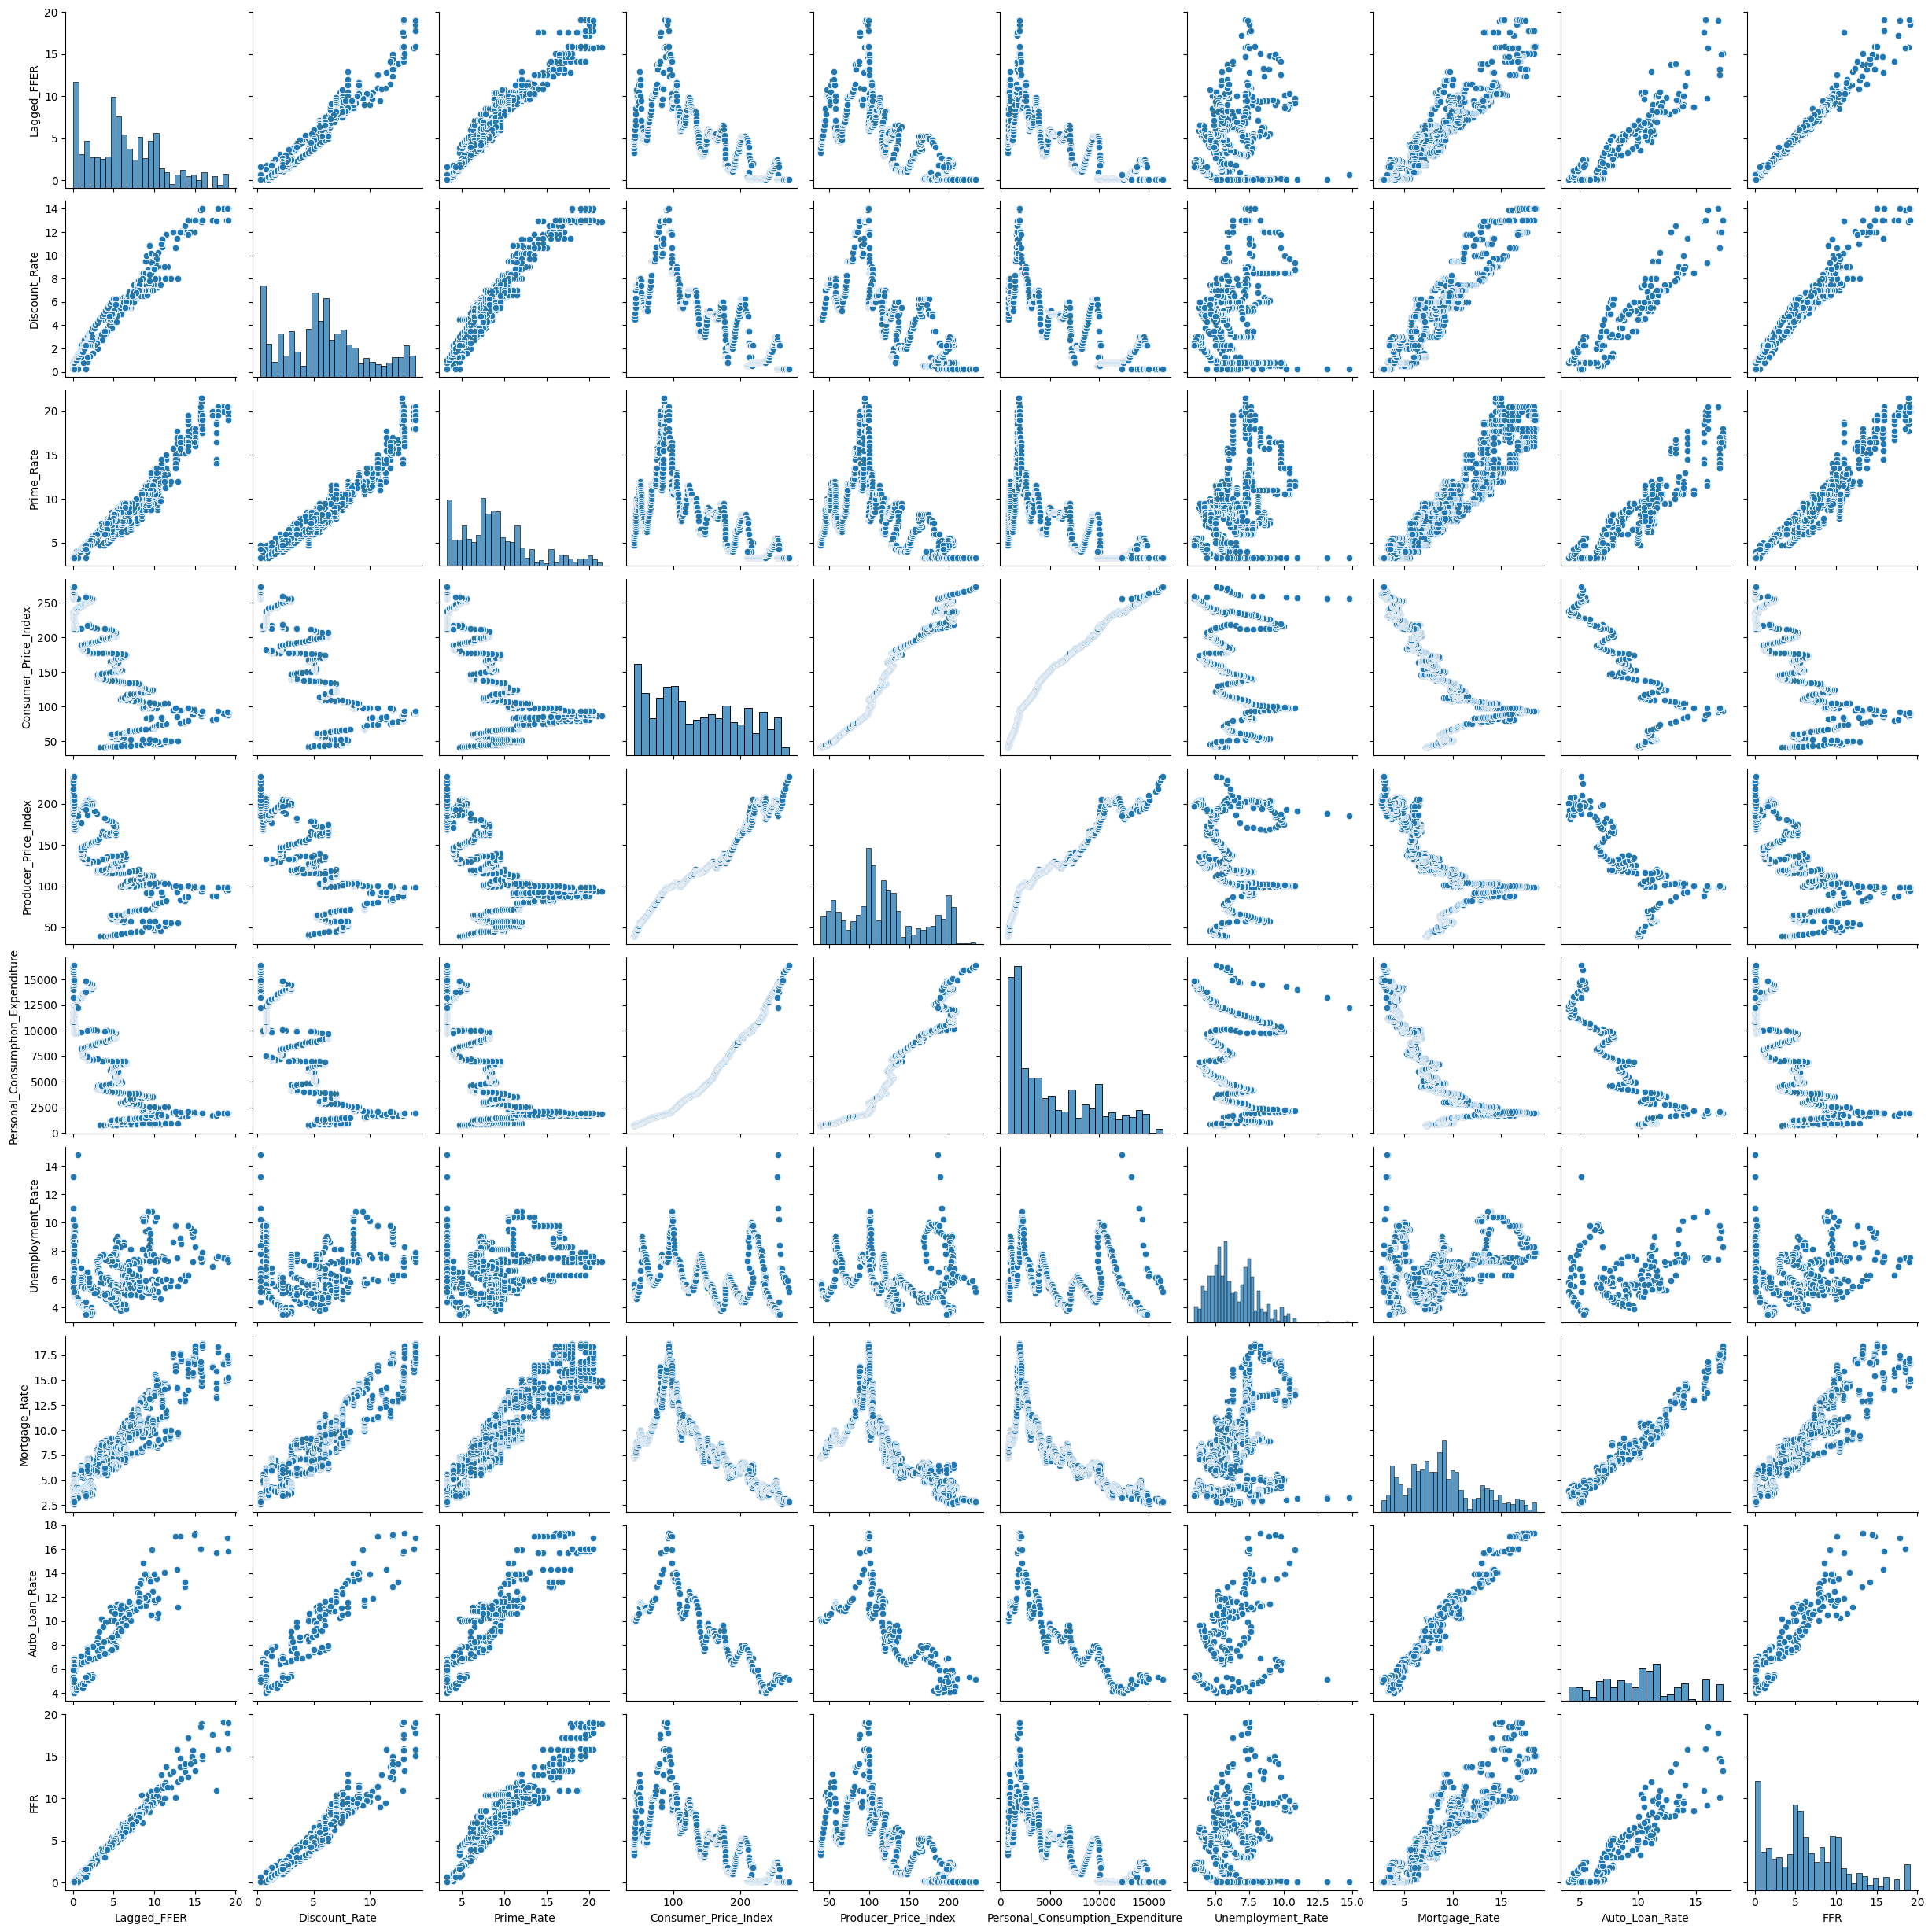

In [ ]:
# Merge the values and plot a pairplot
dataset_list_values = {k:v[['Date', 'Value']] for (k,v) in dataset_list.items()}
dataset_list_values['FFR'] = ffr_data[['Date', 'Value']]

# Rename 'Value' column in each DataFrame to avoid conflicts during merging
for key, df in dataset_list_values.items():
    df.rename(columns={'Value': key}, inplace=True)

# Perform the merge using reduce
merged_values = reduce(lambda left, right: pd.merge(left, right, on='Date', how='inner'), dataset_list_values.values())

# Now you can proceed with your plotting
sns.pairplot(data=merged_values)

<Axes: >

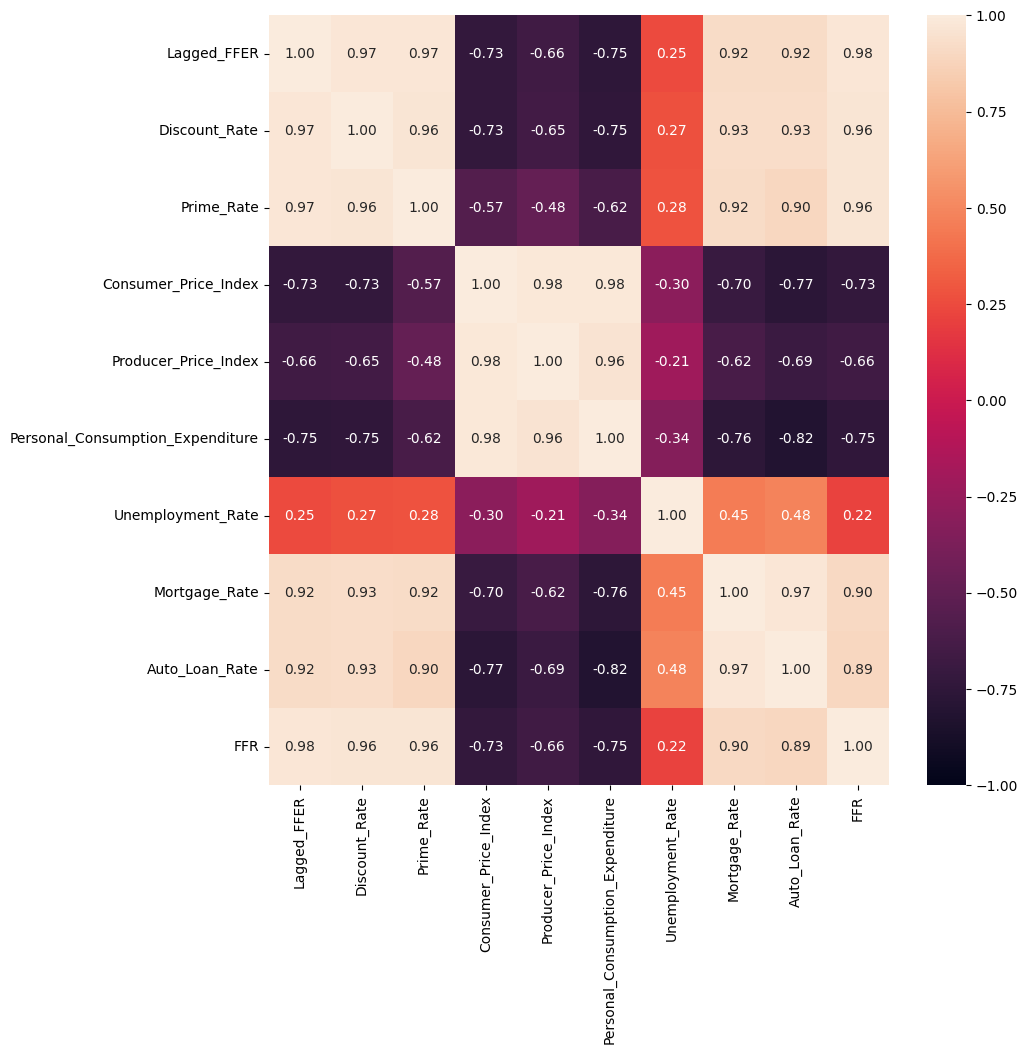

In [ ]:
# Plot a correlation matrix heatmap
f = plt.figure(figsize=(10, 10))
merged_values.set_index('Date', inplace=True)
sns.heatmap(merged_values.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

# Graph Visualizations

In [ ]:
# Scale Data for Graphing
clean_dfs = {}
for label, df in dfs.items():
  clean_df = df.copy()
  clean_df.columns = ['Date', 'Value', 	'ChangePercentMonth', 'ChangePercentYear']
  clean_dfs[label] = clean_df

## Target Comparison (Value)

Federal_Funds_Rate
      Date  Value  ChangePercentMonth  ChangePercentYear
0  1954-07   0.80                 NaN                NaN
1  1954-08   1.22            0.525000                NaN
2  1954-09   1.07           -0.122951                NaN
3  1954-10   0.85           -0.205607                NaN
4  1954-11   0.83           -0.023529                NaN


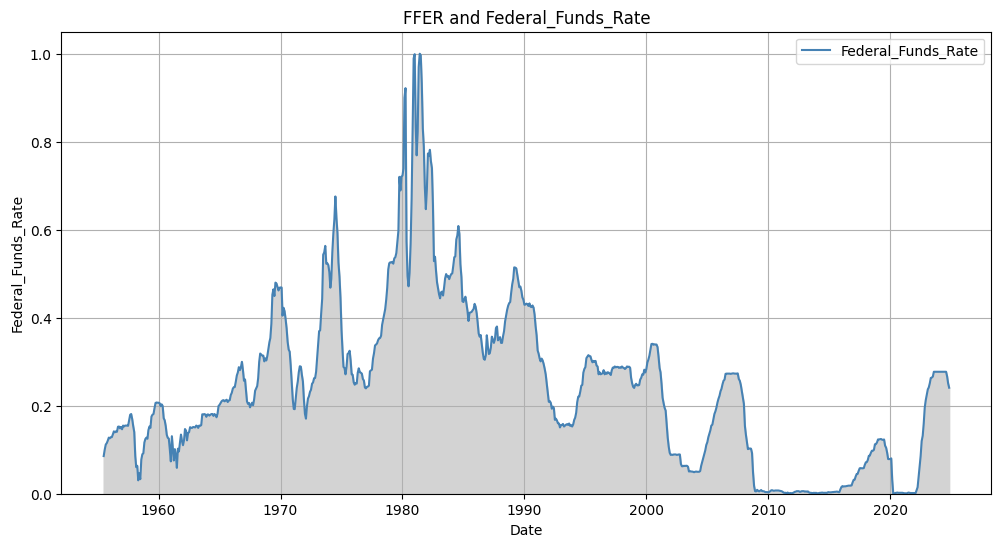

Lagged_FFER
      Date  Value  ChangePercentMonth  ChangePercentYear
0  1954-08   0.80                 NaN                NaN
1  1954-09   1.22            0.525000                NaN
2  1954-10   1.07           -0.122951                NaN
3  1954-11   0.85           -0.205607                NaN
4  1954-12   0.83           -0.023529                NaN


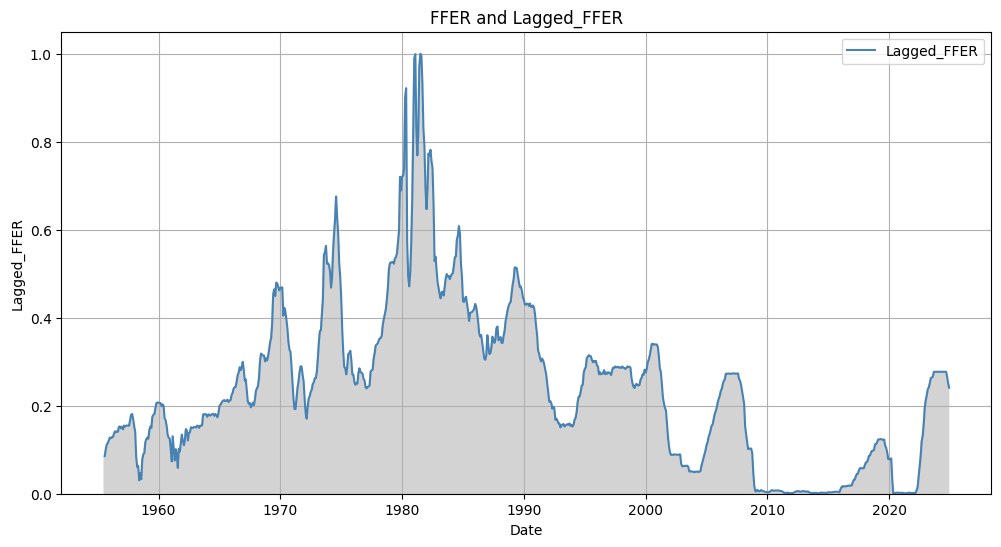

Discount_Rate
      Date  Value  ChangePercentMonth  ChangePercentYear
0  1954-07    1.5                 NaN                NaN
1  1954-08    1.5                 0.0                NaN
2  1954-09    1.5                 0.0                NaN
3  1954-10    1.5                 0.0                NaN
4  1954-11    1.5                 0.0                NaN


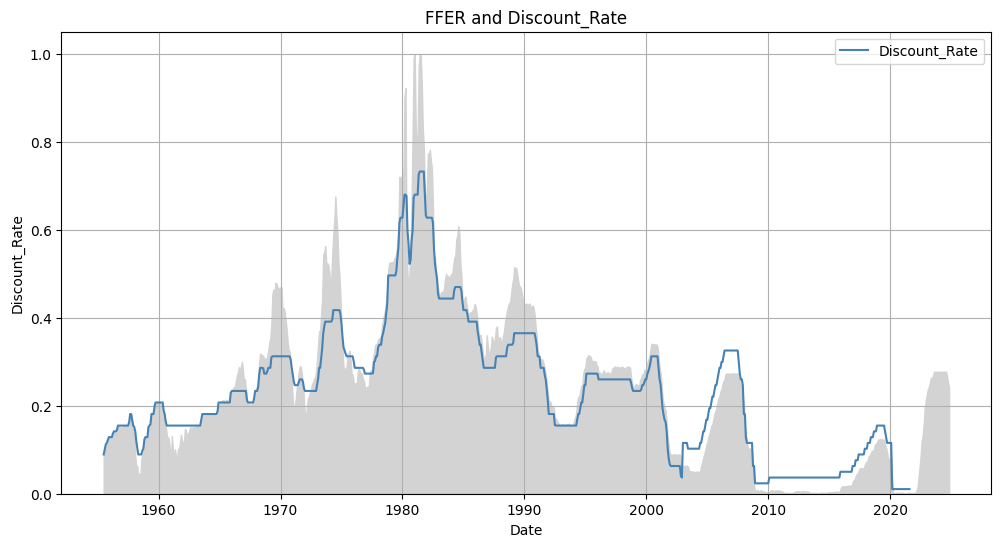

Lagged_DR
      Date  Value  ChangePercentMonth  ChangePercentYear
0  1954-07    1.5                 NaN                NaN
1  1954-08    1.5                 0.0                NaN
2  1954-09    1.5                 0.0                NaN
3  1954-10    1.5                 0.0                NaN
4  1954-11    1.5                 0.0                NaN


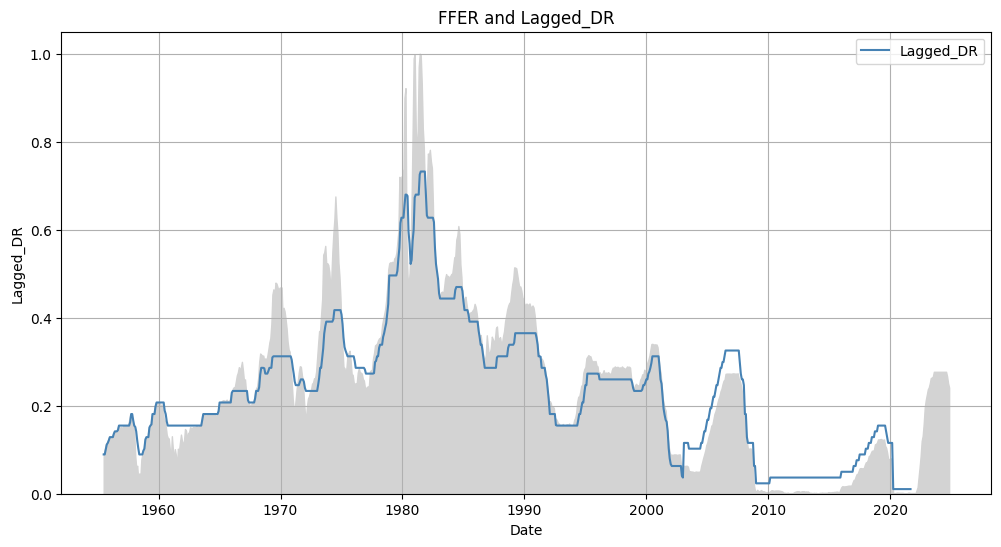

Prime_Rate
      Date  Value  ChangePercentMonth  ChangePercentYear
0  1955-08   3.25                 NaN                NaN
1  1955-08   3.25                 0.0                NaN
2  1955-08   3.25                 0.0                0.0
3  1955-09   3.25                 0.0                0.0
4  1955-10   3.25                 0.0                0.0


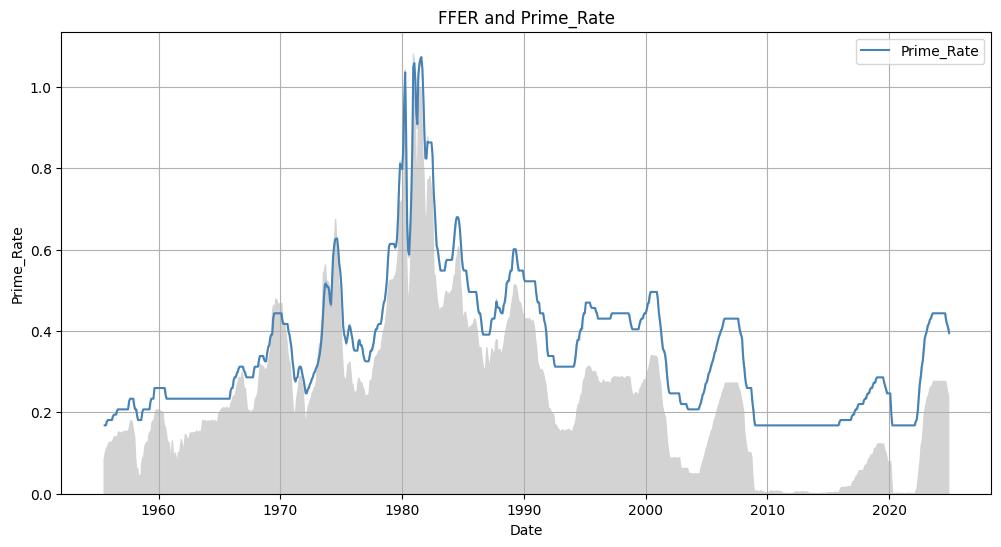

Consumer_Price_Index
      Date  Value  ChangePercentMonth  ChangePercentYear
0  1954-07  26.86                 NaN                NaN
1  1954-08  26.85           -0.000372                NaN
2  1954-09  26.81           -0.001490                NaN
3  1954-10  26.72           -0.003357                NaN
4  1954-11  26.78            0.002246                NaN


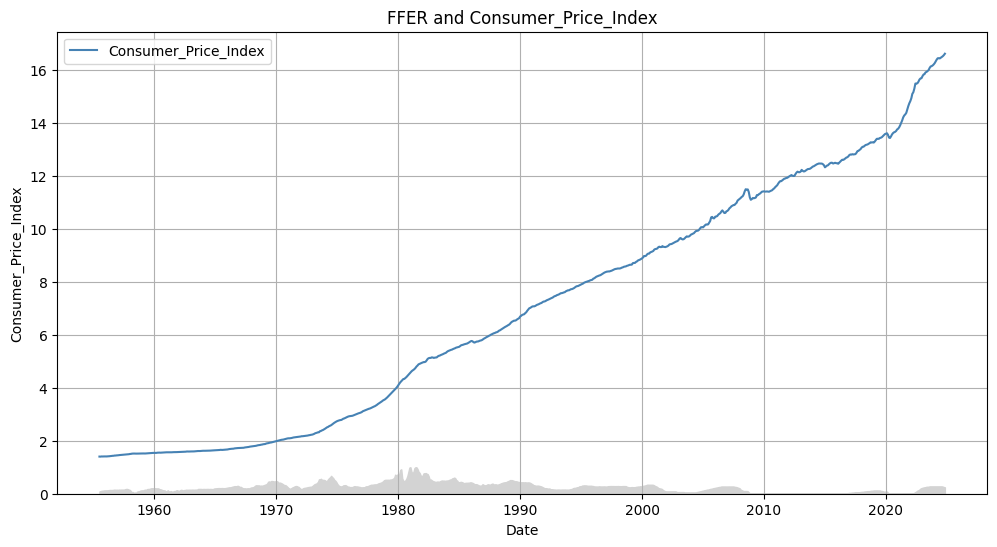

Producer_Price_Index
      Date  Value  ChangePercentMonth  ChangePercentYear
0  1954-07   29.3                 NaN                NaN
1  1954-08   29.3            0.000000                NaN
2  1954-09   29.2           -0.003413                NaN
3  1954-10   29.1           -0.003425                NaN
4  1954-11   29.2            0.003436                NaN


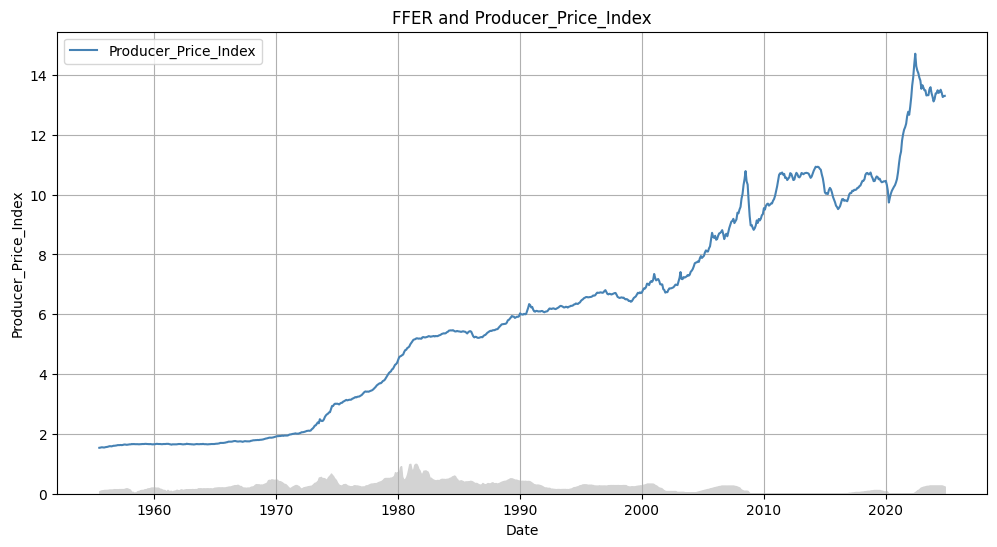

Personal_Consumption_Expenditure
      Date  Value  ChangePercentMonth  ChangePercentYear
0  1959-01  306.1                 NaN                NaN
1  1959-02  309.6            0.011434                NaN
2  1959-03  312.7            0.010013                NaN
3  1959-04  312.2           -0.001599                NaN
4  1959-05  316.1            0.012492                NaN


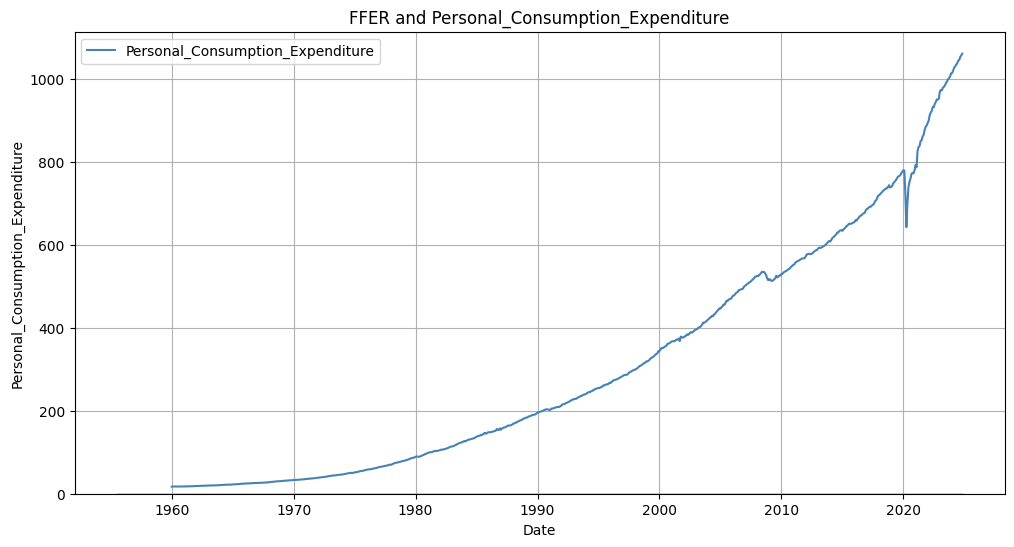

GDP_Recession_Index
      Date   Value  ChangePercentMonth  ChangePercentYear
0  1967-10  3.8348                 NaN                NaN
1  1968-01  1.7614           -0.540680                NaN
2  1968-04  1.2127           -0.311514                NaN
3  1968-07  2.3009            0.897337                NaN
4  1968-10  6.3338            1.752749                NaN


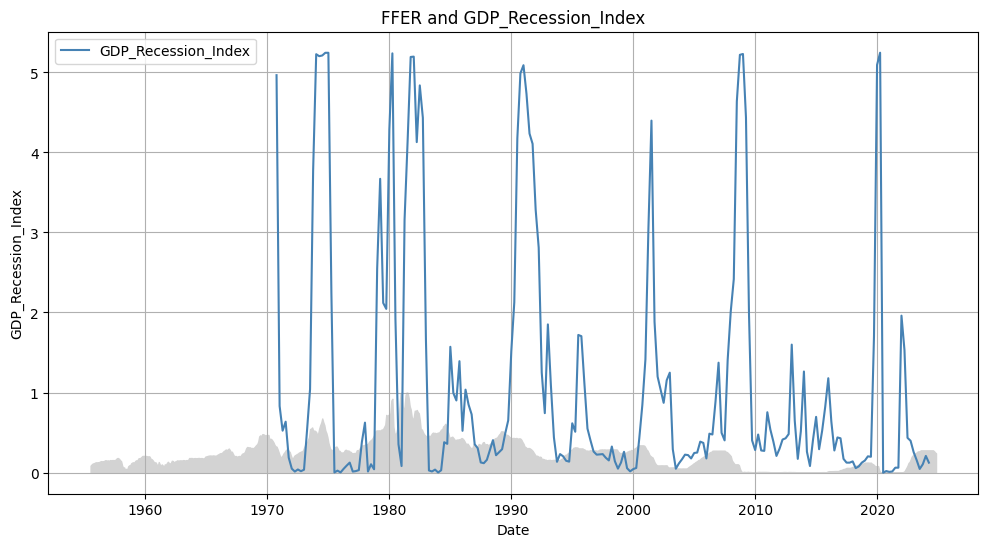

Unemployment_Rate
      Date  Value  ChangePercentMonth  ChangePercentYear
0  1954-07    5.8                 NaN                NaN
1  1954-08    6.0            0.034483                NaN
2  1954-09    6.1            0.016667                NaN
3  1954-10    5.7           -0.065574                NaN
4  1954-11    5.3           -0.070175                NaN


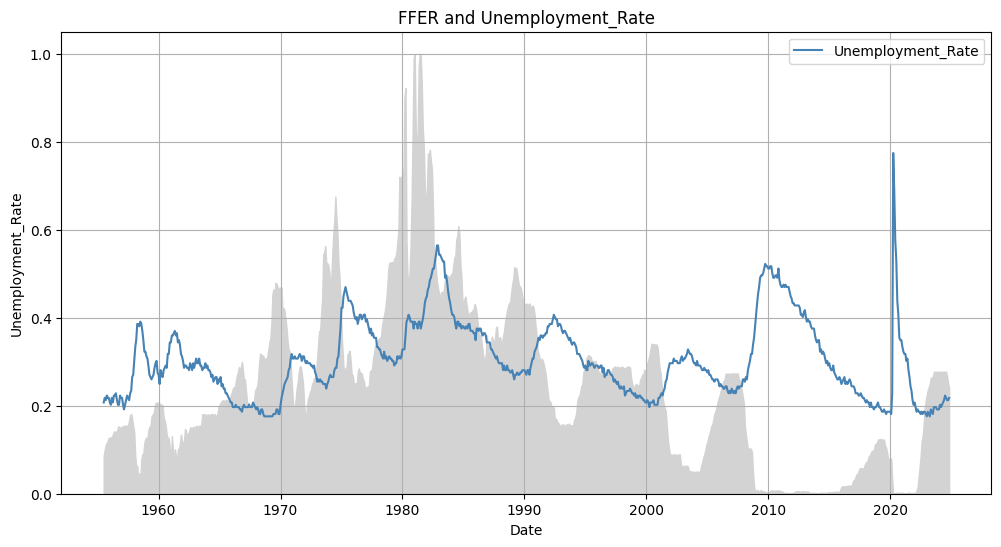

Mortgage_Rate
      Date  Value  ChangePercentMonth  ChangePercentYear
0  1971-04   7.33                 NaN                NaN
1  1971-04   7.31           -0.002729                NaN
2  1971-04   7.31            0.000000                NaN
3  1971-04   7.29           -0.002736                NaN
4  1971-05   7.38            0.012346                NaN


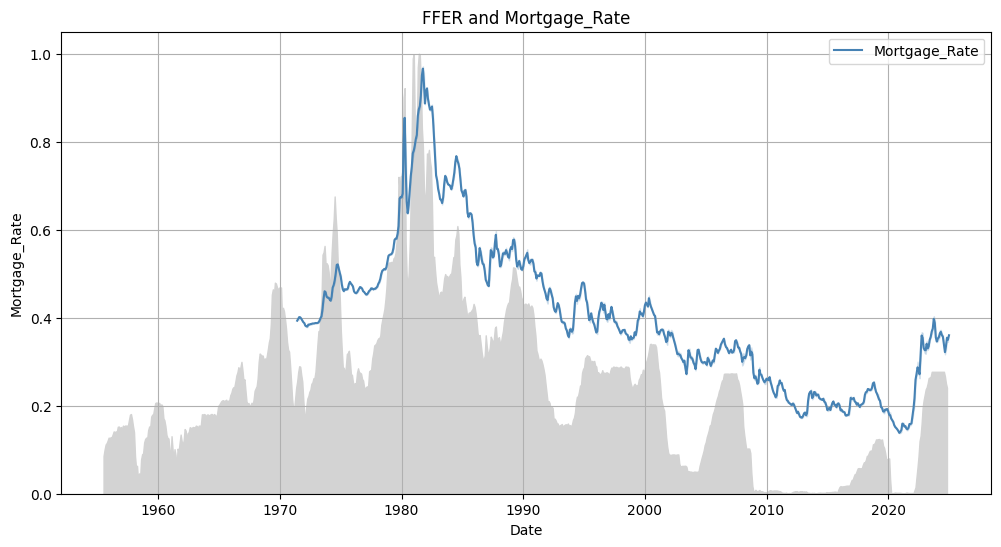

Auto_Loan_Rate
      Date  Value  ChangePercentMonth  ChangePercentYear
0  1972-02  10.20                 NaN                NaN
1  1972-03    NaN            0.000000                NaN
2  1972-04    NaN            0.000000                NaN
3  1972-05   9.96           -0.023529                NaN
4  1972-06    NaN            0.000000                NaN


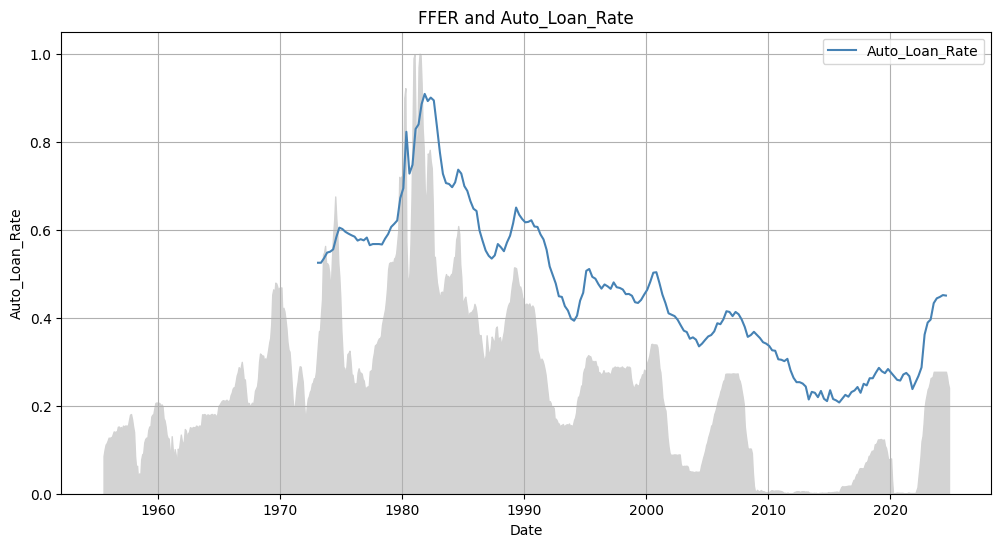

In [ ]:
for label, df in clean_dfs.items():
  print(label)
  print(df.head())
  plot_comparison(ffr_data, df, 'FFER', label)


## Target Comparison (Monthly)

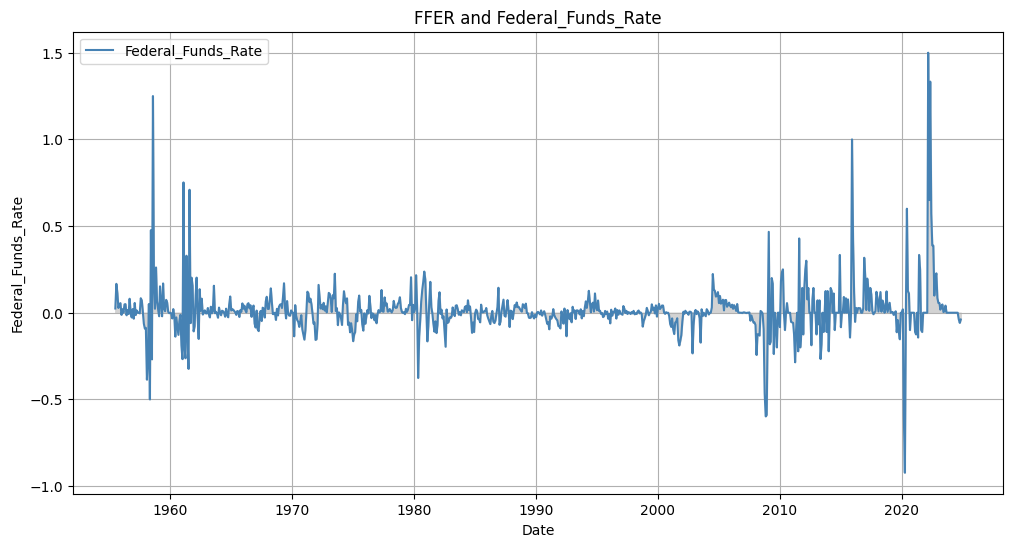

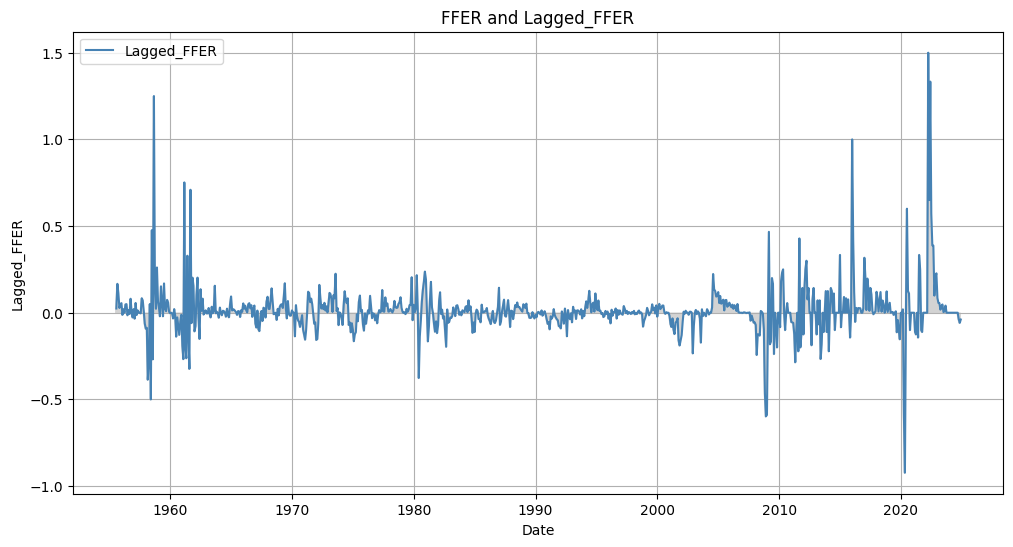

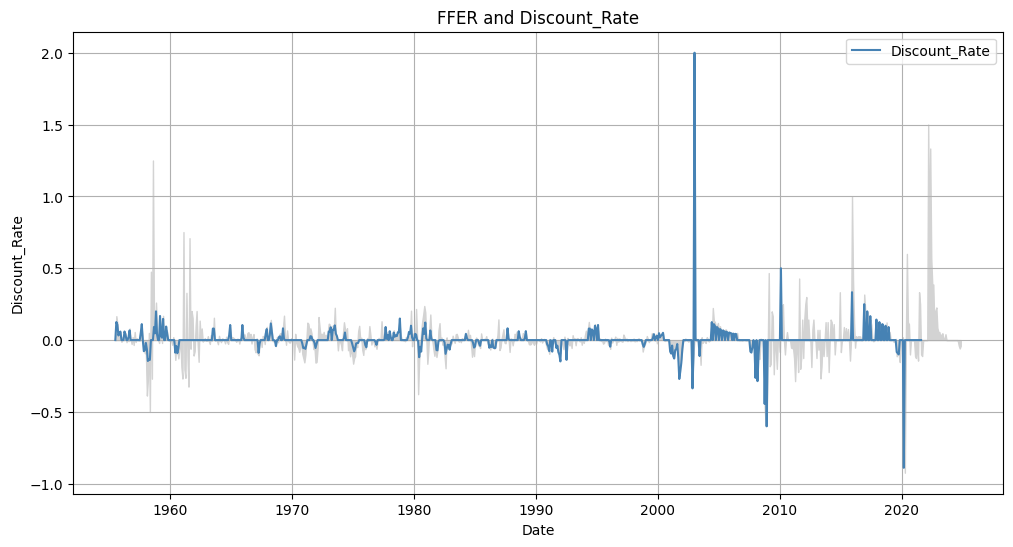

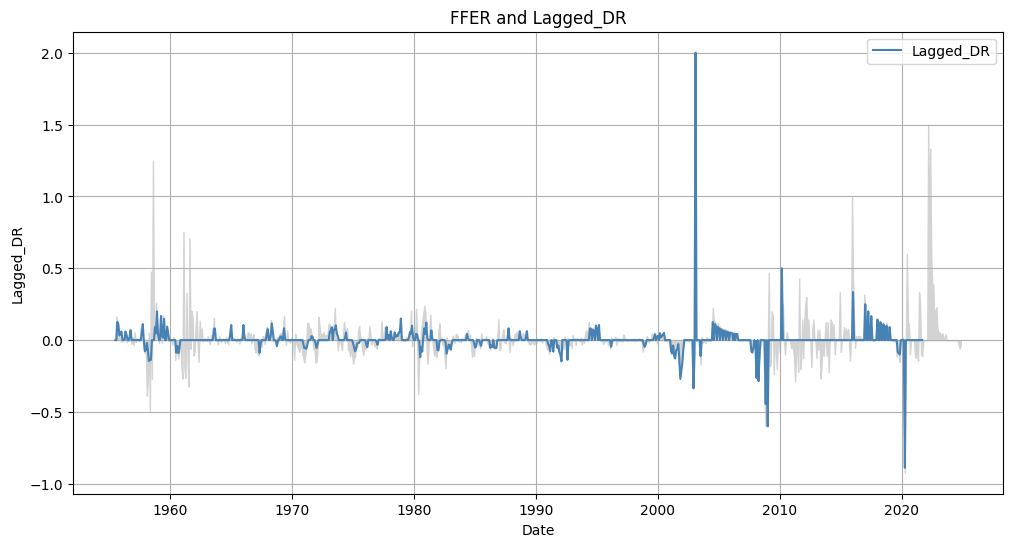

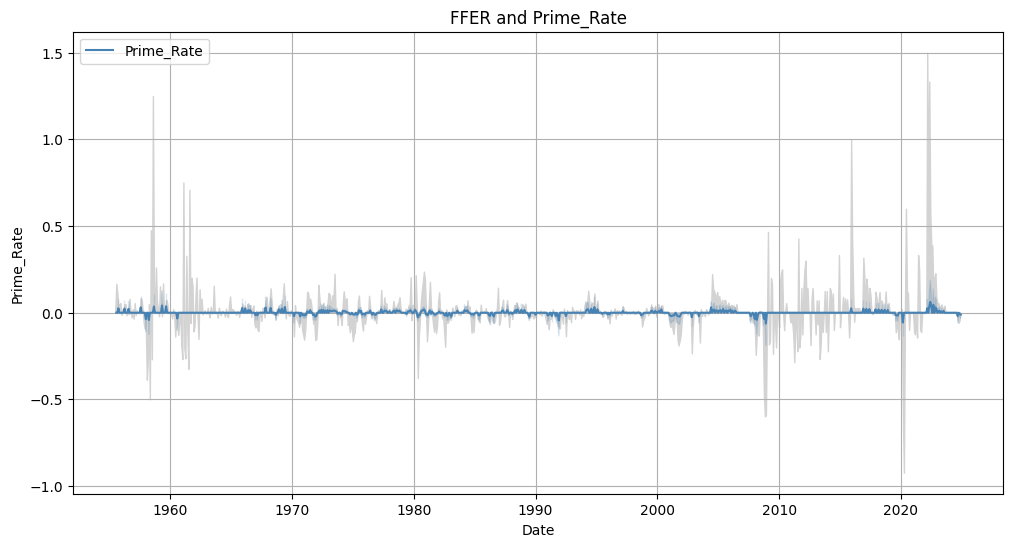

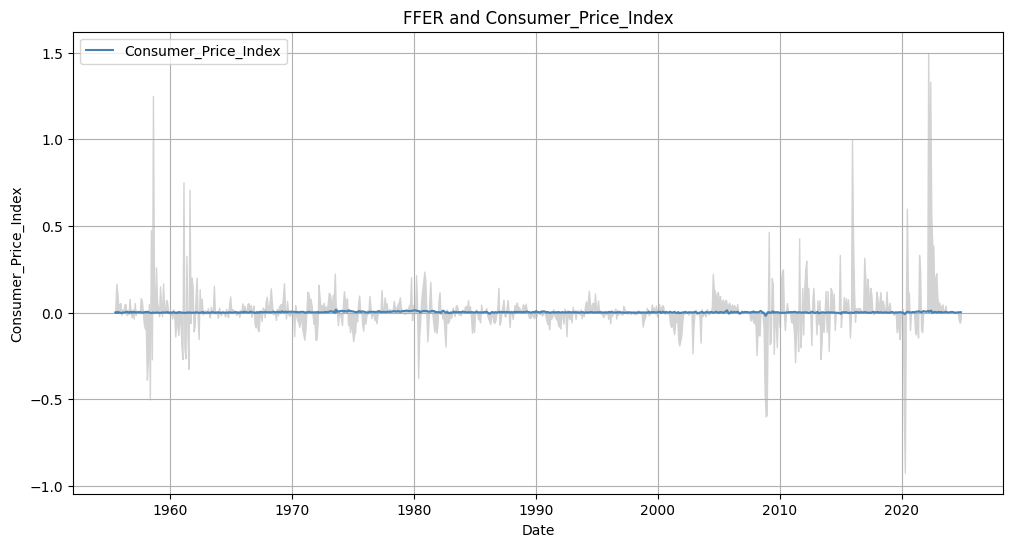

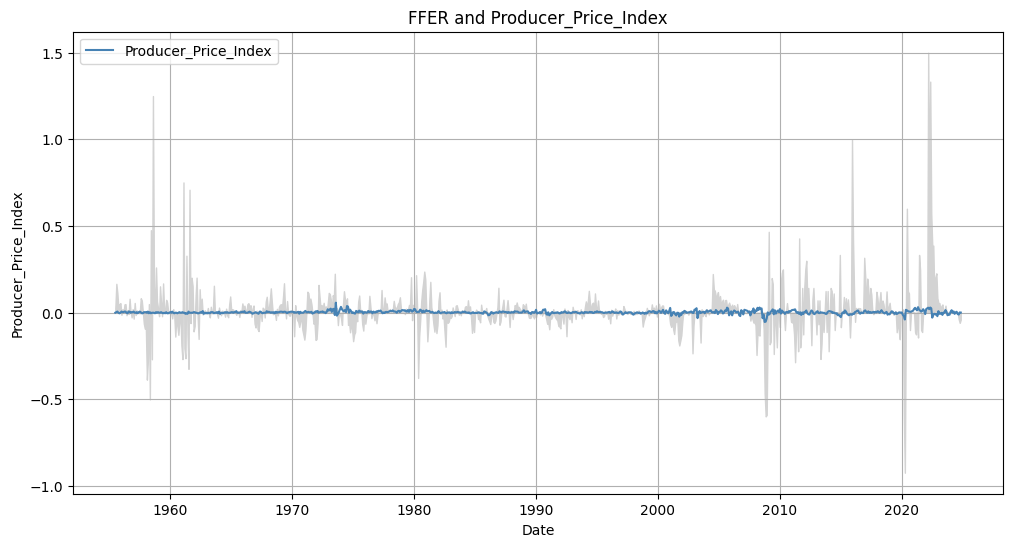

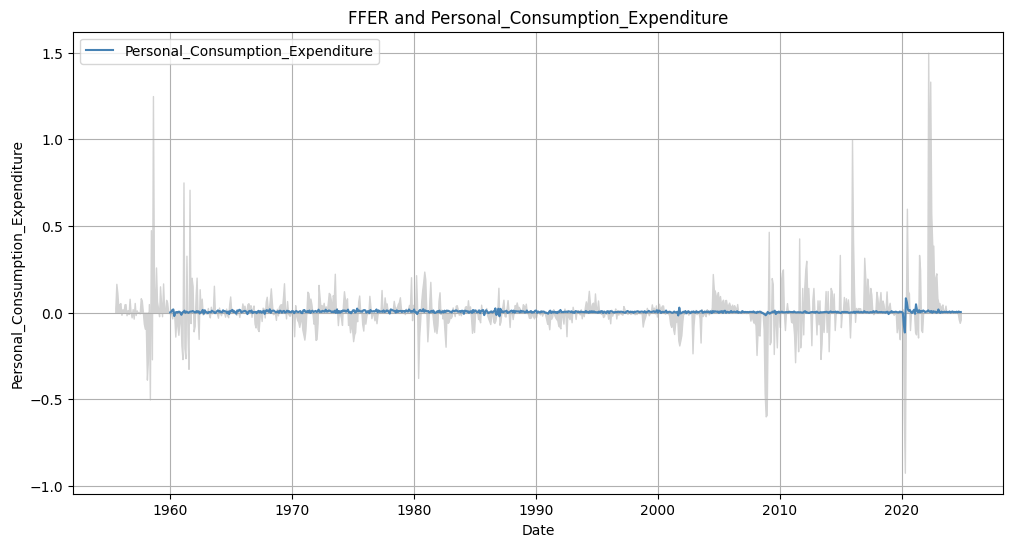

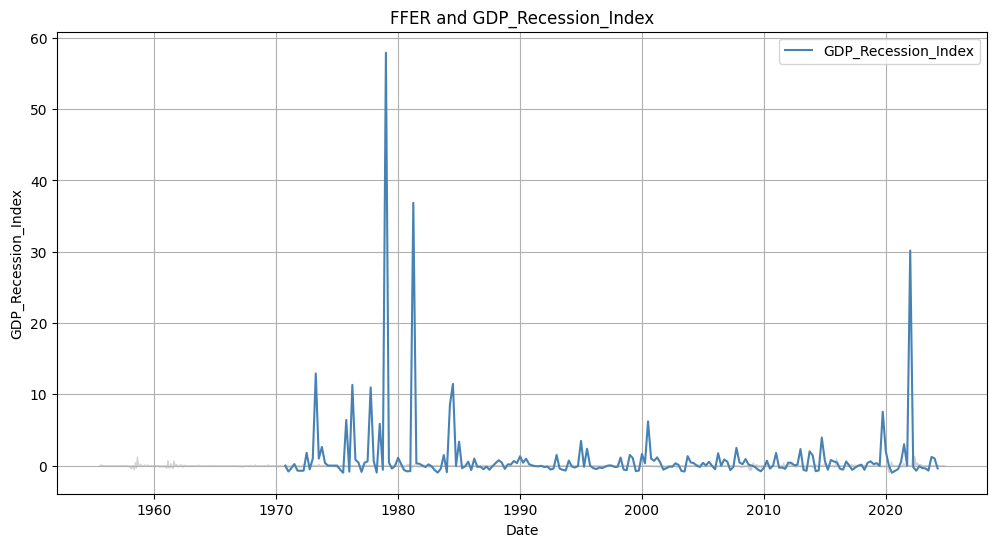

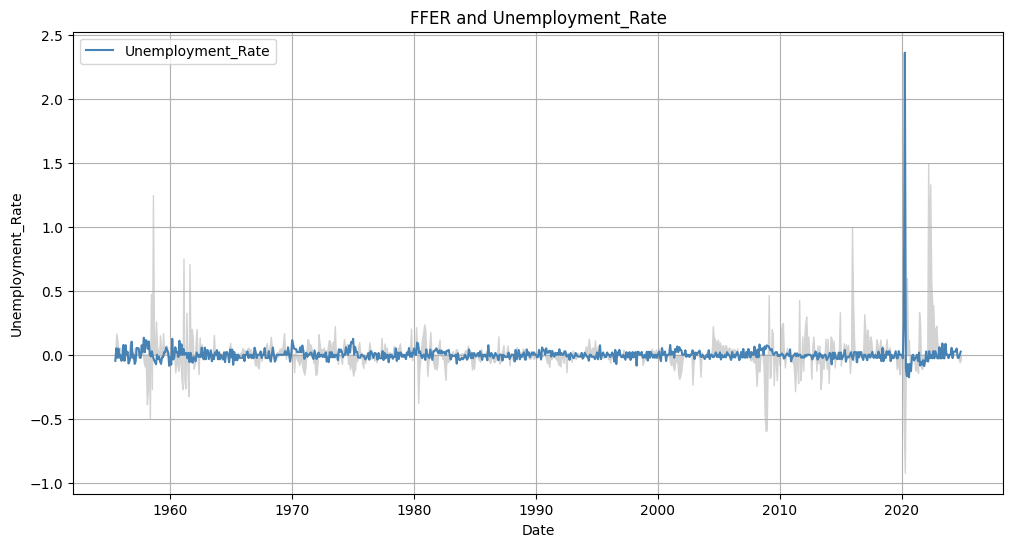

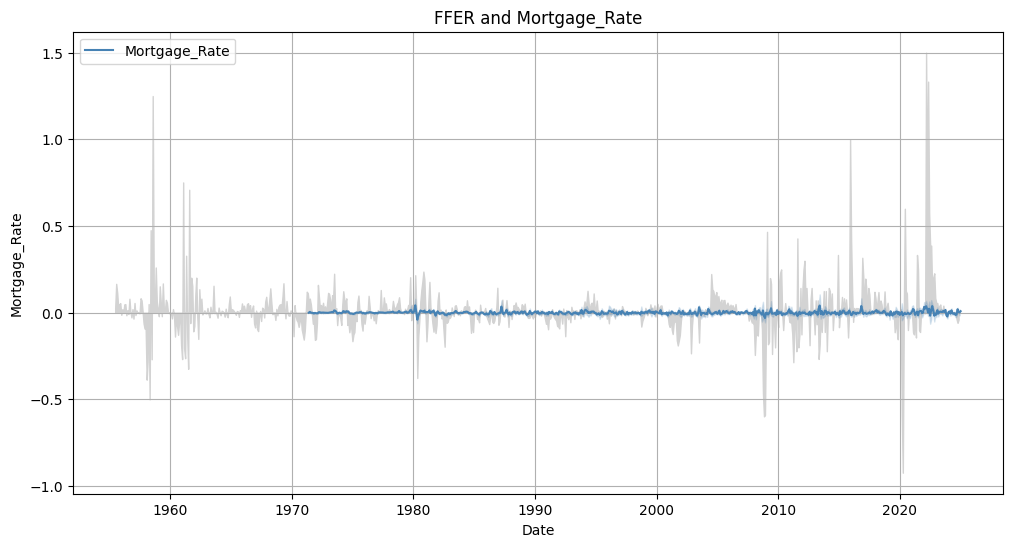

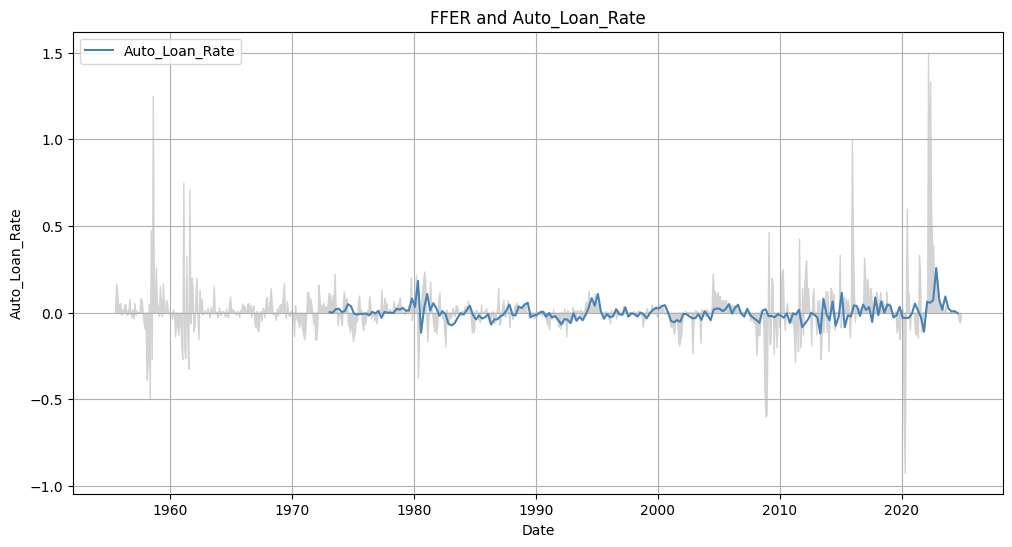

In [ ]:
for label, df in clean_dfs.items():
  plot_comparison(ffr_data, df, 'FFER', label, Value='ChangePercentMonth')

## Target Comparison (Annually)

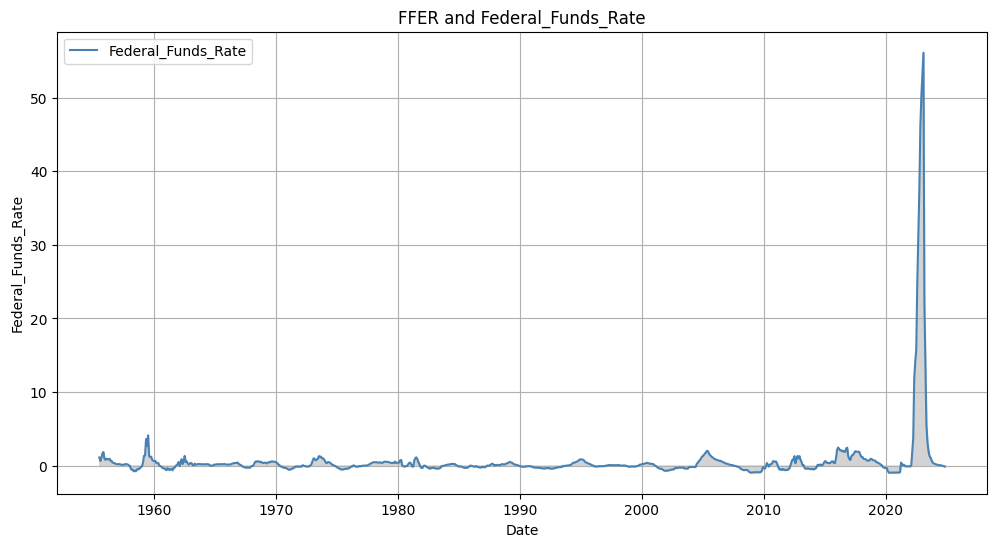

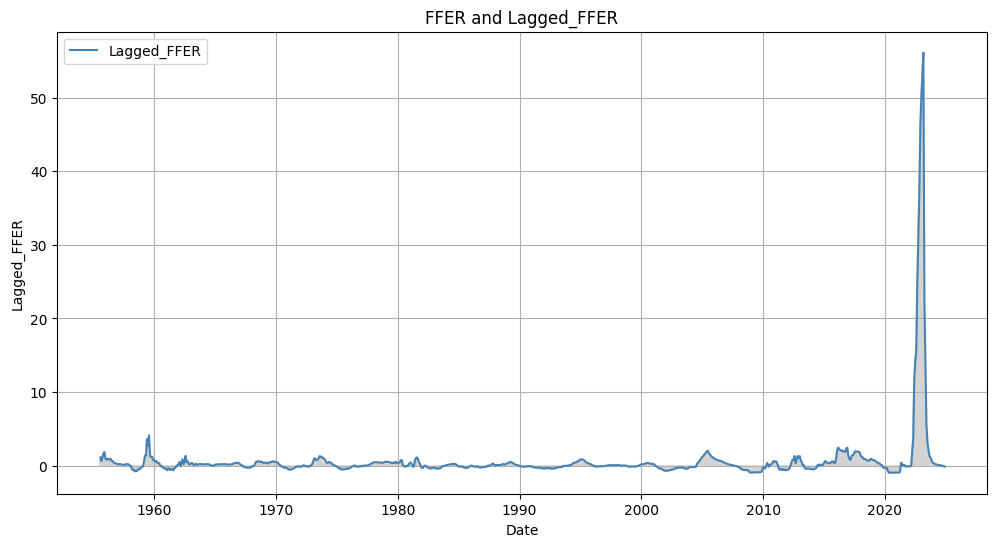

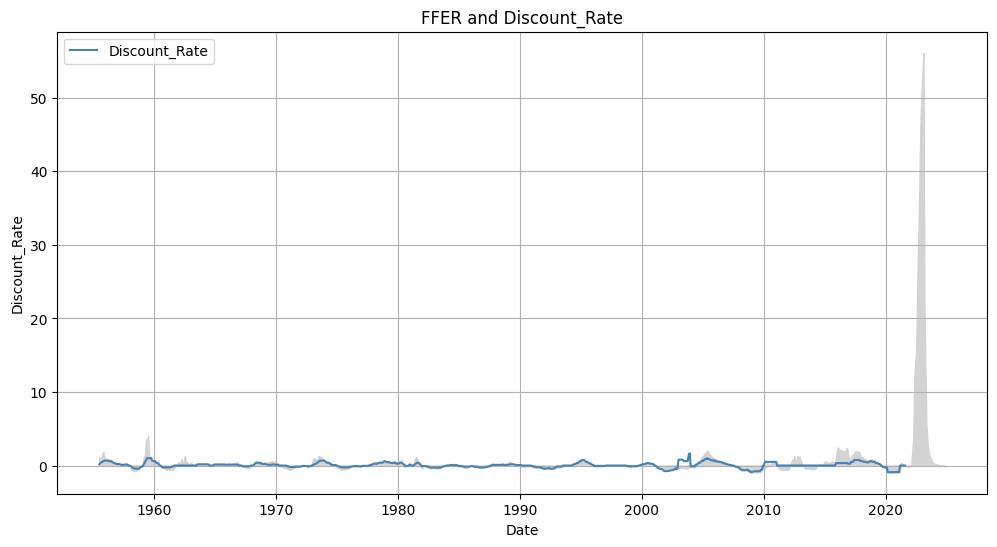

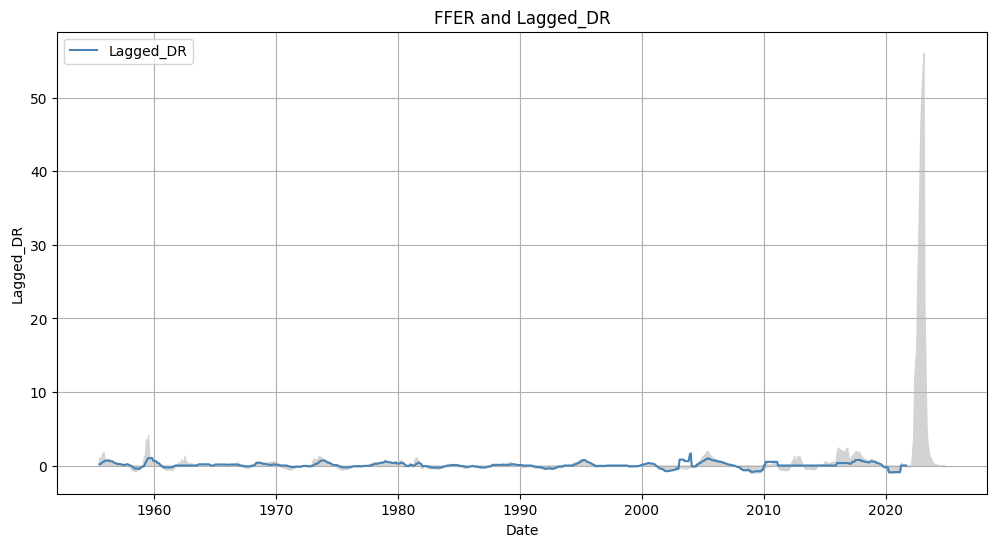

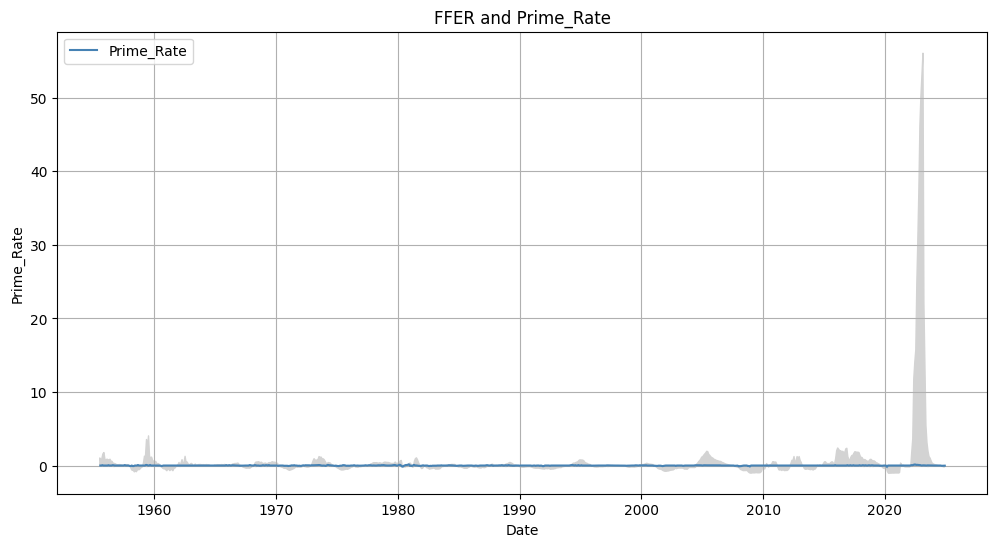

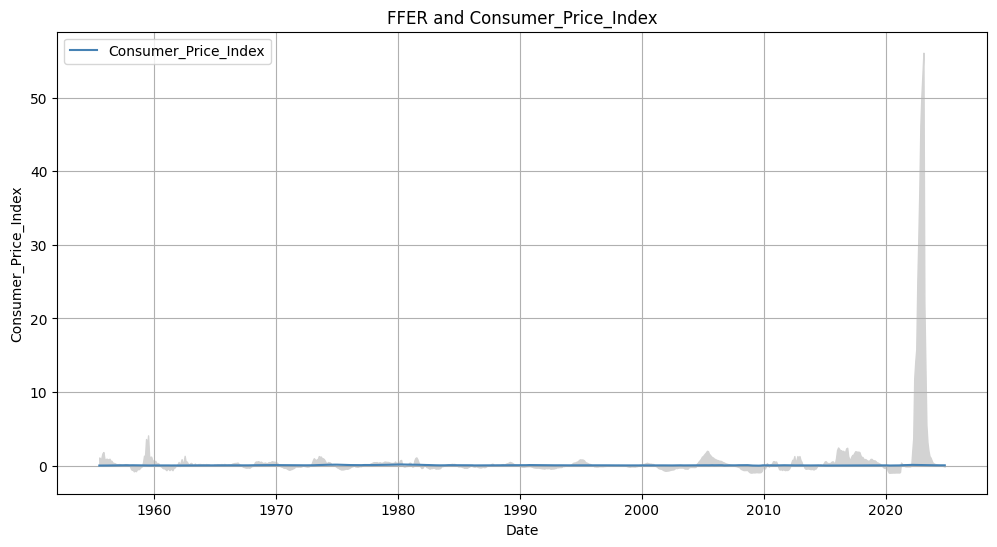

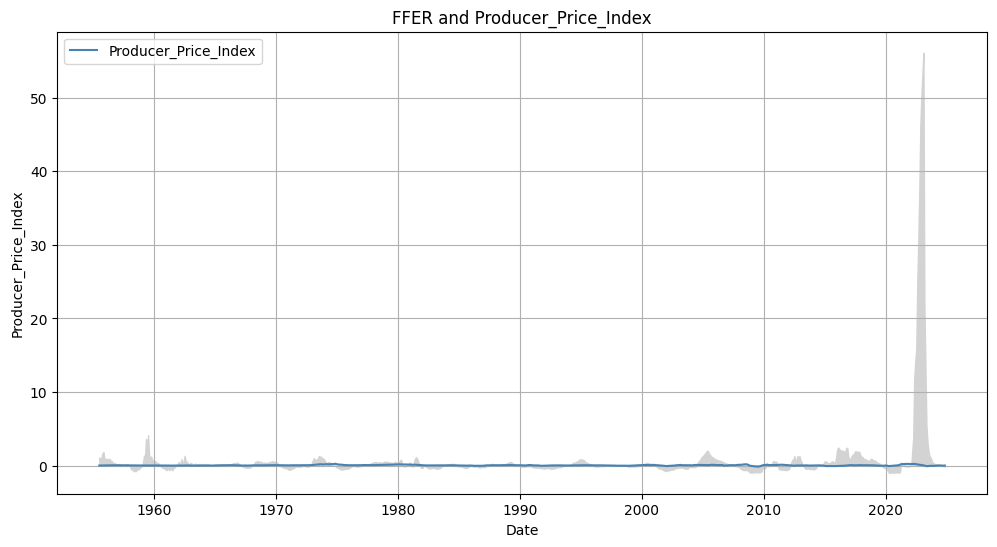

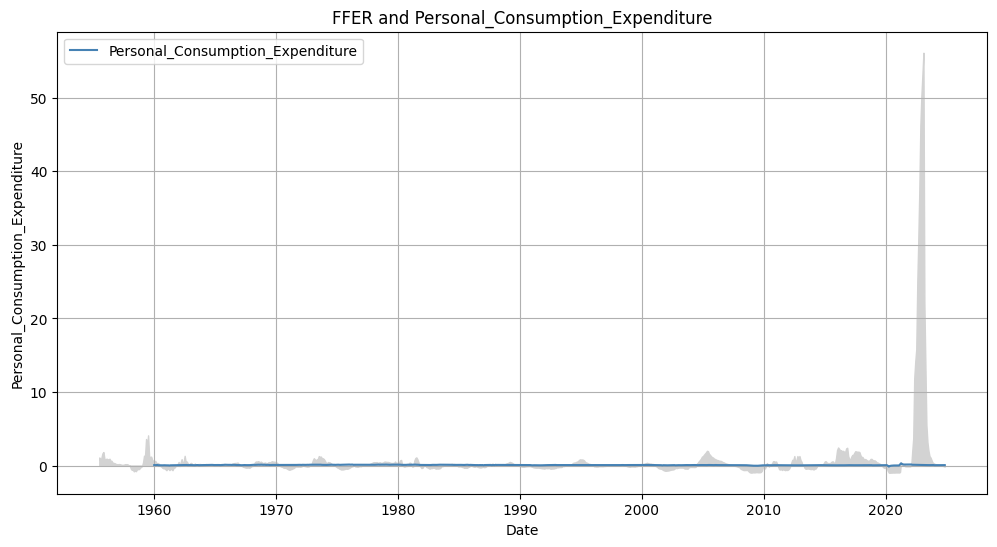

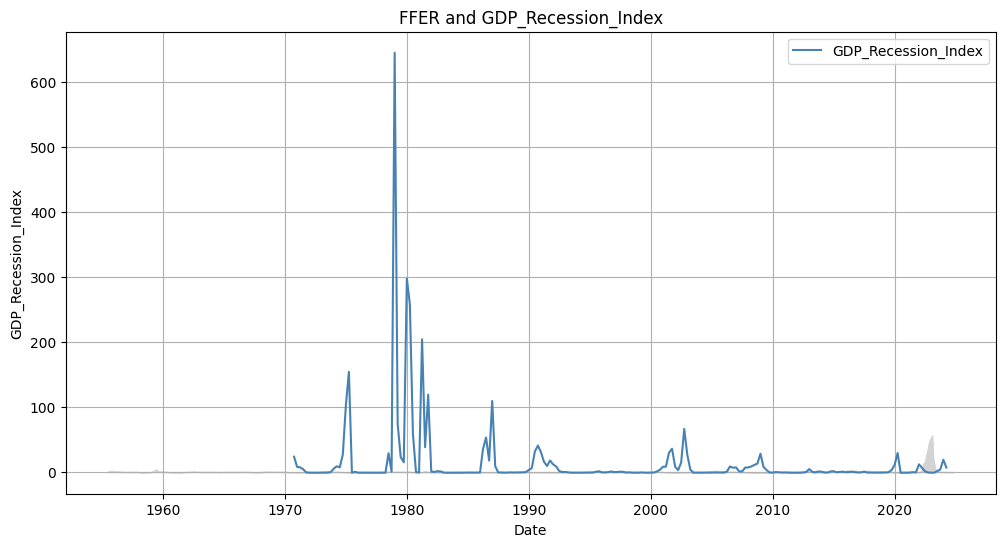

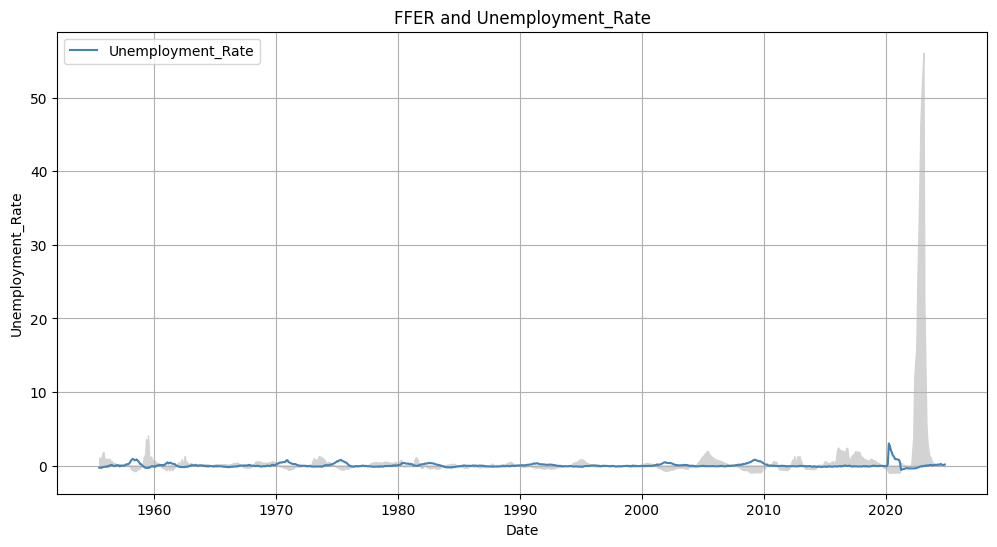

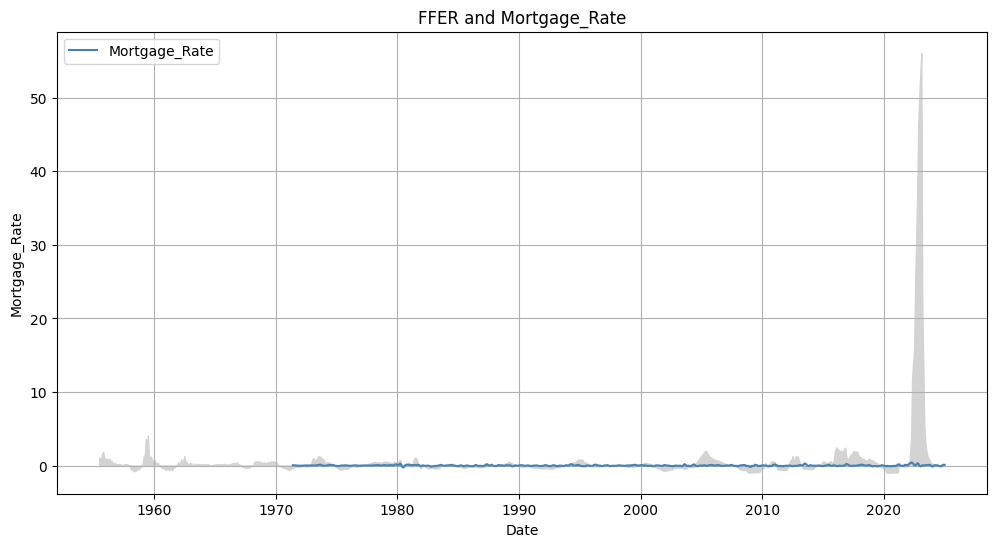

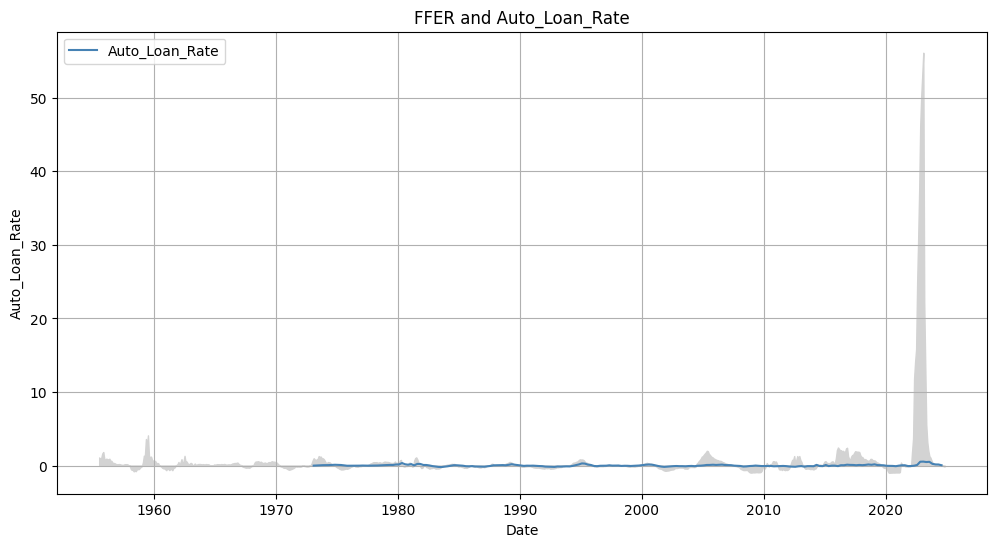

In [ ]:
for label, df in clean_dfs.items():
  plot_comparison(ffr_data, df, 'FFER', label, Value='ChangePercentYear')